# Handwritten Digit Recognition using OpenCV 3.0 with Python

## What is Machine Learning?
Machine Learning gives computers the ability to make predictions or learn from data.  

** Examples:** 
1. Using today’s news articles to predict tomorrows stock price 
2. Using words in a Tweet to predict the sentiment express (e.g. anger, sadness, joy, political views)
3. And filtering email spam.

## The Project: 
Our goal is to build an application which can read the handwritten digits. For this we need some train_data and test_data. OpenCV comes with an image digits.png which has 5000 handwritten digits (500 for each digit). Each digit is a 20x20 image.

So our first step is to split this image into 5000 different digits. For each digit, we flatten it into a single row with 400 pixels. That is our feature set, ie intensity values of all pixels. It is the simplest feature set we can create. We use first 250 samples of each digit as train_data, and next 250 samples as test_data.

In [4]:
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt

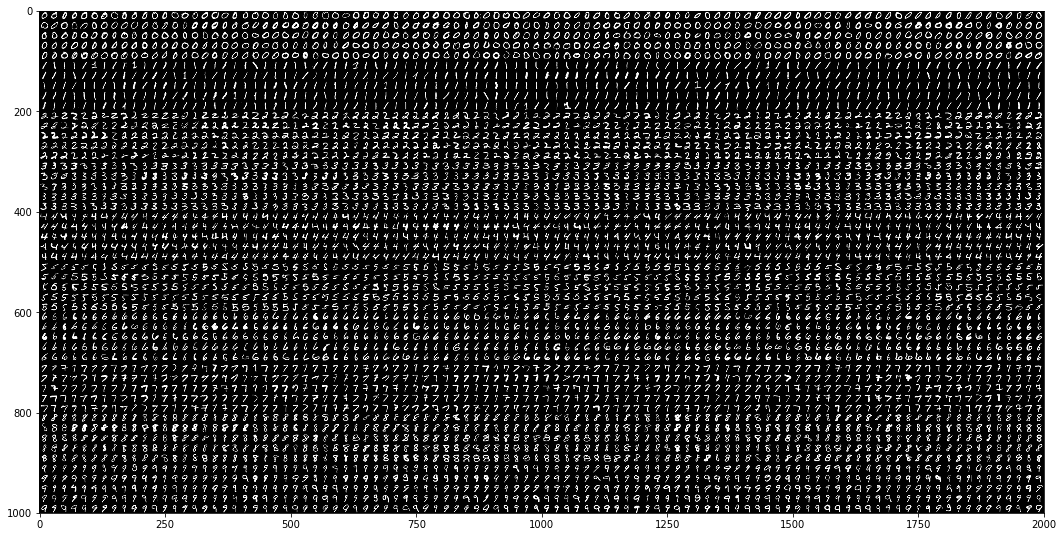

In [12]:
# Let's take a look at our digits dataset
image = cv2.imread('images/digits.png')
plt.figure(figsize=(18,16))
plt.imshow(image)
plt.show()

## Data Preprocessing

In [45]:
# convert the image to grayscale
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

### Vertically and horizontally  split
 Split the image to 5000 cells, each 20x20 size. This gives us a 4-dim array: 50 x 100 x 20 x 20 (50 number in each columns and 100 number in each row )

 The shape of the data before the split (1000, 2000)
 The shape of the data after the vertically  split (20, 2000) The result is one row of numbers


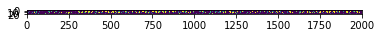

In [43]:
print(" The shape of the data before the split", gray.shape)
# Split an array into multiple sub-arrays vertically (row-wise).
v = np.vsplit(gray,50)[1]
print(" The shape of the data after the vertically  split",c.shape,"The result is one row of numbers")
plt.imshow(v)
plt.show()

 The shape of the data after the horizontally split (20, 20) The result is one number


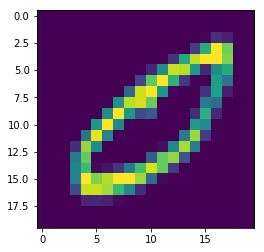

In [44]:
# Split an array into multiple sub-arrays horizontally (column-wise)
h = np.hsplit(v,100)[1]   
print(" The shape of the data after the horizontally split",e.shape,"The result is one number")
plt.imshow(h)
plt.show()

In [46]:
# Split the image to 5000 cells, each 20x20 size
cells = [np.hsplit(row,100) for row in np.vsplit(gray,50)]

# Convert the List data type to Numpy Array of shape (50,100,20,20)
x = np.array(cells)
print ("The shape of our cells array: " + str(x.shape))

The shape of our cells array: (50, 100, 20, 20)


### Split the dataset intor train and test-set:

In [47]:
# Split the full data set into two segments
# One will be used fro Training the model, the other as a test data set
train = x[:,:70].reshape(-1,400).astype(np.float32) # Size = (3500,400)
test = x[:,70:100].reshape(-1,400).astype(np.float32) # Size = (1500,400)

# Create labels for train and test data
k = [0,1,2,3,4,5,6,7,8,9]
train_labels = np.repeat(k,350)[:,np.newaxis]
test_labels = np.repeat(k,150)[:,np.newaxis]

### k-Nearest Neighbour: 
Using OpenCV’s KNN functions are very simple:
1. Initialize our KNN Classifier 
   *  knn = cv2.ml.KNearest_create()
2. Train Model using the training dataset and correct labels 
   * knn.train(train, train_labels)
3. Evaluate Model with the test dataset 
   * ret, result, neighbors, distance = knn.findNearest(test, k) 
       * ret – true or false Boolean indicating if operation was successful 
       * Result – Accuracy i.e. (number correctly classified) / total number of inputs
       * Neighbors – the class of the nearest k neighbors 
       * Distance – Euclidean distance from each point neighbor

In [120]:
# Initiate kNN, train the data, then test it with test data for k=3
knn = cv2.ml.KNearest_create()
knn.train(train, cv2.ml.ROW_SAMPLE,train_labels)
ret, result, neighbors, distance = knn.findNearest(test, k=3)

# Now we check the accuracy of classification
# For that, compare the result with test_labels and check which are wrong
matches = result == test_labels
correct = np.count_nonzero(matches)
accuracy = correct * (100.0 / result.size)
print("Accuracy is = %.2f" % accuracy + "%")

Accuracy is = 93.47%


To improve the accuracy we can add more data for training.

## Processing a New Image:
1. Grayscale
2. Gaussian Blur
3. Canny Edges
4. Extract Contours
5. Get Biunding Rectangle
6. Filter Contours
7. Crop Bounding Rectangle of blurred image
8. Binarize and then make into a 20x20 Square
9. Convert to 1 x 400 array
10. Input into Classifier

### Step 1: define the required Functions

In [121]:
# Define our functions

def x_cord_contour(contour):
    # This function take a contour from findContours
    # it then outputs the x centroid coordinates
    
    if cv2.contourArea(contour) > 10:
        M = cv2.moments(contour)
        return (int(M['m10']/M['m00']))
    else:
        return (-1)

def makeSquare(not_square):
    # This function takes an image and makes the dimenions square
    # It adds black pixels as the padding where needed
    
    BLACK = [0,0,0]
    img_dim = not_square.shape
    height = img_dim[0]
    width = img_dim[1]
    #print("Height = ", height, "Width = ", width)
    if (height == width):
        square = not_square
        return square
    else:
        doublesize = cv2.resize(not_square,(2*width, 2*height), interpolation = cv2.INTER_CUBIC)
        height = height * 2
        width = width * 2
        #print("New Height = ", height, "New Width = ", width)
        if (height > width):
            pad = int((height - width)/2)
            #print("Padding = ", pad)
            doublesize_square = cv2.copyMakeBorder(doublesize,0,0,pad,\
                                                   pad,cv2.BORDER_CONSTANT,value=BLACK)
        else:
            pad = (width - height)/2
            #print("Padding = ", pad)
            doublesize_square = cv2.copyMakeBorder(doublesize,pad,pad,0,0,\
                                                   cv2.BORDER_CONSTANT,value=BLACK)
    doublesize_square_dim = doublesize_square.shape
    #print("Sq Height = ", doublesize_square_dim[0], "Sq Width = ", doublesize_square_dim[1])
    return doublesize_square


def resize_to_pixel(dimensions, image):
    # This function then re-sizes an image to the specificied dimenions
    
    buffer_pix = 4
    dimensions  = dimensions - buffer_pix
    squared = image
    r = float(dimensions) / squared.shape[1]
    dim = (dimensions, int(squared.shape[0] * r))
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    img_dim2 = resized.shape
    height_r = img_dim2[0]
    width_r = img_dim2[1]
    BLACK = [0,0,0]
    if (height_r > width_r):
        resized = cv2.copyMakeBorder(resized,0,0,0,1,cv2.BORDER_CONSTANT,value=BLACK)
    if (height_r < width_r):
        resized = cv2.copyMakeBorder(resized,1,0,0,0,cv2.BORDER_CONSTANT,value=BLACK)
    p = 2
    ReSizedImg = cv2.copyMakeBorder(resized,p,p,p,p,cv2.BORDER_CONSTANT,value=BLACK)
    img_dim = ReSizedImg.shape
    height = img_dim[0]
    width = img_dim[1]
    #print("Padded Height = ", height, "Width = ", width)
    return ReSizedImg

### Step 2: Load the Image:

In [130]:
image = cv2.imread('images/numbers.jpg')
image_res = image.copy()
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

# Blur image then find edges using Canny 
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

edged = cv2.Canny(blurred, 30, 150)

# Fint Contours
_,contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#Sort out contours left to right by using their x cordinates
contours = sorted(contours, key = x_cord_contour, reverse = False)

# Create empty array to store entire number
full_number = []

# loop over the contours
for c in contours:
    # compute the bounding box for the rectangle
    (x, y, w, h) = cv2.boundingRect(c)    

    #cv2.drawContours(image, contours, -1, (0,255,0), 3)
    #cv2.imshow("Contours", image)

    if w >= 5 and h >= 30:
        roi = blurred[y:y + h, x:x + w]
        ret, roi = cv2.threshold(roi, 127, 255,cv2.THRESH_BINARY_INV)
        squared = makeSquare(roi)
        final = resize_to_pixel(20, squared)
        final_array = final.reshape((1,400))
        final_array = final_array.astype(np.float32)
        ret, result, neighbours, dist = knn.findNearest(final_array, k=1)
        number = str(int(float(result[0])))
        full_number.append(number)
        # draw a rectangle around the digit, the show what the
        # digit was classified as
        cv2.rectangle(image_res, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv2.putText(image_res, number, (x , y + 155),
            cv2.FONT_HERSHEY_COMPLEX, 2, (255, 0, 0), 2)
        
cv2.destroyAllWindows()
print ("The number is: " + ''.join(full_number))

The number is: 13540


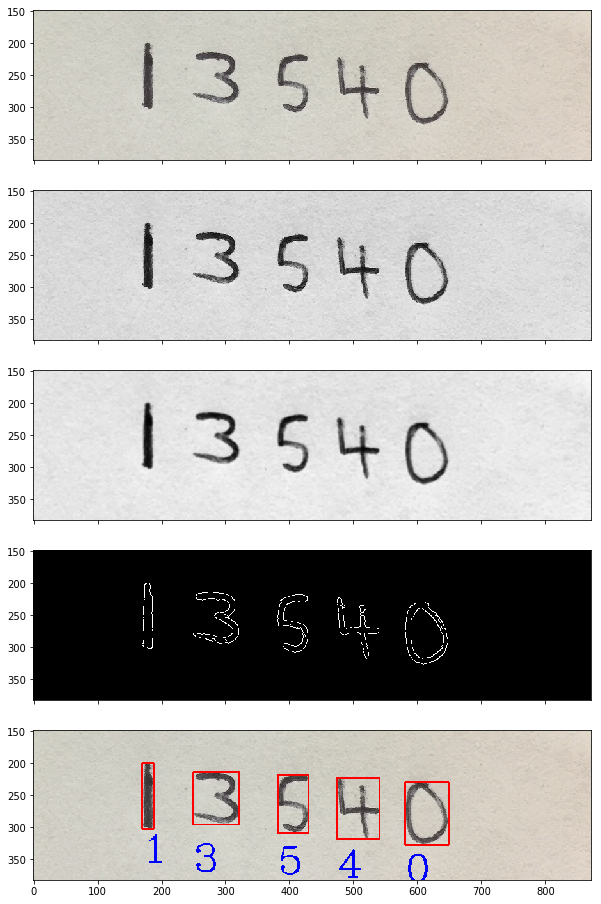

In [131]:
f, ax = plt.subplots(5, 1, sharex='col', sharey='row',figsize=(10,16))

ax[0].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
ax[1].imshow(gray,'gray')
ax[2].imshow(blurred,'gray')
ax[3].imshow(edged,'gray')
ax[4].imshow(cv2.cvtColor(image_res,cv2.COLOR_BGR2RGB))

plt.show()